In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import itertools

In [3]:
def daugman(center, start_r, gray_img):
    """return maximal intense radius for given center
    center -- tuple(x, y)
    start_r -- int
    gray_img -- grayscale picture as np.array(), it should be square
    """
    # get separate coordinates
    x, y = center
    # get img dimensions
    h, w = gray_img.shape
    # for calculation convinience
    img_shape = np.array([h, w])
    c = np.array(center)
    # define some other vars
    tmp = []
    mask = np.zeros_like(gray)

    # for every radius in range
    # we are presuming that iris will be no bigger than 1/3 of picture
    for r in range(start_r, int(h/3)):
        # draw circle on mask
        cv2.circle(mask, center, r, 255, 1)
        # get pixel from original image
        radii = gray_img & mask  # it is faster than np or cv2
        # normalize
        tmp.append(radii[radii > 0].sum()/(2*3.1415*r))
        # refresh mask
        mask.fill(0)
        
    # calculate delta of radius intensitiveness
    tmp = np.array(tmp)
    tmp = tmp[1:] - tmp[:-1]
    # aply gaussian filter
    tmp = abs(cv2.GaussianBlur(tmp[:-1], (1, 5), 0))
    # get maximum value
    idx = np.argmax(tmp)
    # return value, center coords, radius
    return tmp[idx], [center, idx + start_r]

In [4]:
def find_iris(gray, start_r):
    """Apply daugman() on every pixel in calculated image slice
        gray -- graysacale img as np.array()
        start_r -- initial radius as int
    Selection of image slice guarantees that every
    radius will be drawn in iage borders, so we need to check it (speed up)
    
    To speed up the whole process we need to pregenerate all centers for detection
    """
    _, s = gray.shape
    # reduce step for better accuracy
    # 's/3' is the maximum radius of a daugman() search
    a = range(0 + int(s/3), s - int(s/3), 3)
    all_points = list(itertools.product(a, a))
    
    values = []
    coords = []
    
    for p in all_points:
        tmp = daugman(p, start_r, gray)
        if tmp is not None:
            val, circle = tmp
            values.append(val)
            coords.append(circle)
    
    # return the radius with biggest intensiveness delta on image
    # [(xc, yc), radius]
    return coords[np.argmax(values)]

## Tests

True

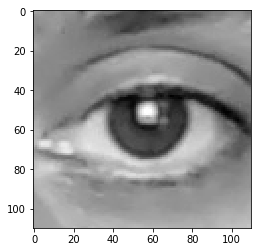

In [5]:
# read, square crop and grayscale image of an eye
img = cv2.imread('eye.jpg')
img = img[20:130, 20:130]
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
start_r = 10
plt.imshow(gray, cmap='gray')
cv2.imwrite('sq_eye.jpg', img)

In [7]:
%%timeit
find_iris(gray, 10)
# ON SERVER: 64.6 ms ± 619 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# ON NOTEBOOK: 389 ms ± 4.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# it is 73-85 time faster than https://github.com/Fejcvk/Iris-Comparator/blob/master/daugman.py

381 ms ± 4.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
# get result
find_iris(gray, 10)

[(57, 54), 20]

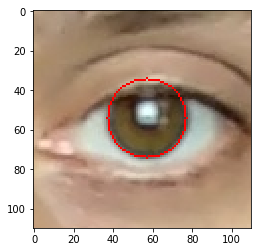

In [8]:
# plot result
out = img.copy()
cv2.circle(out, (57, 54), 20, (0, 0, 255), 1)
plt.imshow(out[::,::,::-1])

In [ ]:
# import cProfile
# function profiling
# cProfile.run('find_iris(gray, 15, all_points)')